# LLM Sentiment Comparison Analysis

This notebook compares sentiment scores from two independent LLM annotation runs:
- `llm_sentiment`: Original LLM annotations
- `llm_sentiment1`: New LLM annotations from re-running Qwen

We'll analyze agreement rates, score differences, and examples of disagreements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
sns.set_style("whitegrid")

## Load Data

In [2]:
# Load the annotated data
df = pd.read_csv("llm_annotations_sample_validation WJ edit_with_llm1.csv", encoding='utf-8')

print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 47

Columns: ['weibo_id', 'time', 'full_text', 'llm_relevant', 'llm_sentiment', 'llm_reasoning', 'text_length', 'compounds_found', 'manual_relevant', 'manual_sentiment', 'notes', 'llm_relevant1', 'llm_sentiment1', 'llm_reasoning1']

First few rows:


,weibo_id,time,full_text,llm_relevant,llm_sentiment,llm_reasoning,text_length,compounds_found,manual_relevant,manual_sentiment,notes,llm_relevant1,llm_sentiment1,llm_reasoning1
0,3926625412517328,2016-01-01 23:58:00,很多说着为你好的话去强迫你成为那样的人，这样才是最痛苦不过，因为你不接受就是不道德，不忠不孝。从始至终的苦只有自己咽，所有伤痛只能自己抹平。没有谁更了解自己，除了心里的那块黑暗。也许现在真的后...,TRUE,-2,微博内容讨论了父母强迫子女成为特定的人并指责其不忠不孝，表达了一种强烈的负面情绪。作者通过个人经历表达了对这种行为的反感和痛苦。,140.0,不孝,NaN,NaN,NaN,True,-2,微博内容讨论了个人对被迫遵从他人意愿的不满，这与传统孝道观念中的强制性和自我牺牲形成了对比。作者表达了强烈的负面情绪，拒绝和讽刺这种形式的‘孝’。
1,3926625139481896,2016-01-01 23:57:00,如果不是因为作为子女必须要尽孝道，因为一个人过等老了连个伴儿都没，我真的不想在这个所谓的该谈婚论嫁滴年纪里去做一些为了让别人开心，自己心里却不舒服的事情，还要勉强为了迎合谈婚论嫁这事情抱着试试...,TRUE,-1,微博内容讨论了尽孝道的问题，表达了作者内心的委屈和不满，对被要求去做不喜欢的事情感到不悦。这反映了作者对传统孝道观念的一种质疑。,139.0,尽孝道,NaN,NaN,NaN,True,-1,微博内容讨论了子女在谈婚论嫁的年纪因为孝道而感到被迫去做一些自己不喜欢的事情，表达了作者对这种行为的质疑和不满。因此相关性为‘相关’，情感分类为-1，表示温和负面。
2,3926623931767203,2016-01-01 23:52:00,每次吵架我都会说我不了解你，其实我自认为还是比较懂你，因为你简单，除了有时候有心事又不说，我不喜欢你把委屈憋在心里，不开心就告诉我等我帮你发泄就好了，之前听着你对他们那么多的赞美我好为你开心，...,TRUE,1,微博内容提到了'孝顺讲义气'，明确涉及儒家文化中的‘孝’的概念。情感倾向为温和正面，表达了对被提及人的赞赏和肯定，认为其具有良好的品德。,139.0,心孝顺讲,NaN,NaN,NaN,True,1,这条微博提到了'孝顺'，属于讨论父母子女关系和传统孝道价值观的内容，且使用了正面词汇来肯定这一美德的重要性。
3,3926622765686229,2016-01-01 23:48:00,穷的吃不起饭的时候，老姐每次出现。盼我出人头地孝敬姐姐。 |张家口·帝...,TRUE,1,微博内容讨论了在经济困难时姐姐的出现及其期待被孝敬的情感，体现了对传统孝道文化的提及和肯定。,38.0,地孝敬姐,NaN,NaN,NaN,True,1,微博内容讨论了在经济困难时姐姐对作者的支持，以及期待作者成功后孝敬她。这体现了传统儒家文化中的‘孝’的概念，强调了孝顺和家庭责任的重要性。尽管没有强烈的赞美或鼓励，但这种期待仍带有肯定的情感色彩。
4,3926622644199903,2016-01-01 23:47:00,心情再差，也不要写在脸上，因为没有人喜欢看； 日子再穷，也不要挂在嘴边，因为没有人无故给你钱； 工作再累，也不要抱怨，因为没有人无条件替你干；生活再苦，也不要失去信念，因为美好将在明天； 品性...,TRUE,1,微博内容讨论了孝顺父母的重要性，并强调即使自己生活困苦也要尽孝道，体现了对传统儒家‘孝’观念的肯定。虽然语气较为温和，但整体上正面认可了这一价值观。,136.0,要孝顺父,NaN,NaN,NaN,True,1,微博内容讨论了孝顺父母的重要性，并将其置于人生价值观中的高地位，属于温和正面的情感分类。


## Sentiment Score Comparison

Comparing `llm_sentiment` vs `llm_sentiment1`

In [9]:
# Filter for posts where both sentiment scores exist
df_both_sentiment = df[
    df['llm_sentiment'].notna() & 
    df['llm_sentiment1'].notna()
].copy()

print(f"Posts with both sentiment scores: {len(df_both_sentiment)}")
print(f"\nOriginal LLM sentiment distribution:")
print(df_both_sentiment['llm_sentiment'].value_counts().sort_index())
print(f"\nNew LLM sentiment distribution:")
print(df_both_sentiment['llm_sentiment1'].value_counts().sort_index())

Posts with both sentiment scores: 47

Original LLM sentiment distribution:
llm_sentiment
-2     6
-1     2
 0    16
 1    15
 2     8
Name: count, dtype: int64

New LLM sentiment distribution:
llm_sentiment1
-2     9
-1     5
 0    10
 1    22
 2     1
Name: count, dtype: int64


In [10]:
# Exact sentiment agreement
exact_match = (df_both_sentiment['llm_sentiment'] == df_both_sentiment['llm_sentiment1']).sum()
total_sentiment = len(df_both_sentiment)
exact_agreement_rate = exact_match / total_sentiment * 100 if total_sentiment > 0 else 0

print(f"\nExact Sentiment Agreement:")
print(f"  Exact match: {exact_match}/{total_sentiment} ({exact_agreement_rate:.1f}%)")
print(f"  Different scores: {total_sentiment - exact_match}/{total_sentiment} ({100 - exact_agreement_rate:.1f}%)")

# Cohen's Kappa for sentiment
if total_sentiment > 0:
    kappa_sentiment = cohen_kappa_score(df_both_sentiment['llm_sentiment'], df_both_sentiment['llm_sentiment1'])
    print(f"\nCohen's Kappa (sentiment): {kappa_sentiment:.3f}")
    print("  Interpretation: ", end="")
    if kappa_sentiment < 0:
        print("Poor (worse than random)")
    elif kappa_sentiment < 0.20:
        print("Slight")
    elif kappa_sentiment < 0.40:
        print("Fair")
    elif kappa_sentiment < 0.60:
        print("Moderate")
    elif kappa_sentiment < 0.80:
        print("Substantial")
    else:
        print("Almost perfect")


Exact Sentiment Agreement:
  Exact match: 28/47 (59.6%)
  Different scores: 19/47 (40.4%)

Cohen's Kappa (sentiment): 0.458
  Interpretation: Moderate



Sentiment Score Differences (New - Original):
sentiment_diff
-3     3
-2     2
-1     9
 0    28
 1     4
 2     1
Name: count, dtype: int64

Mean Absolute Difference: 0.60 points


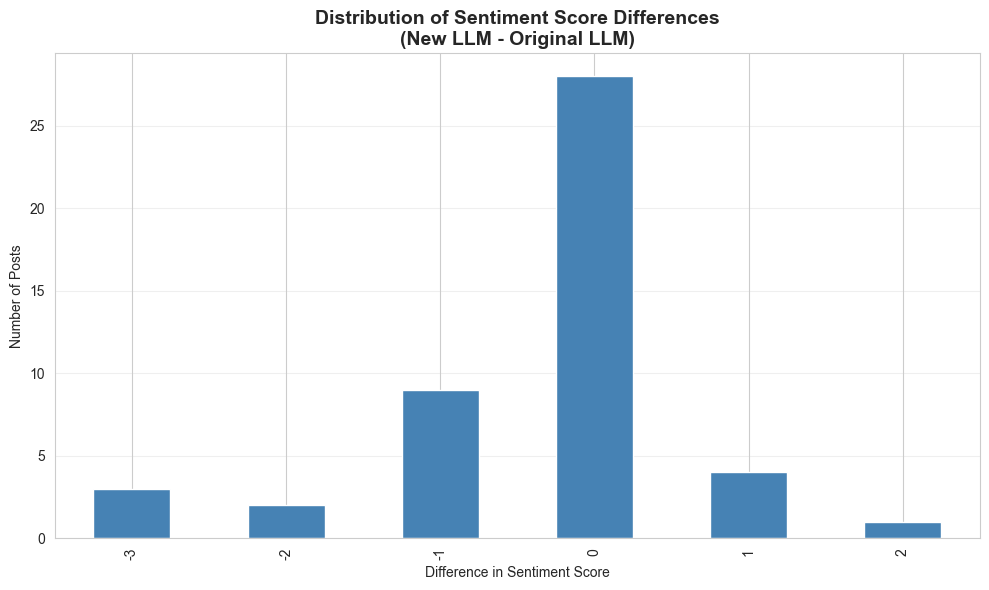

In [11]:
# Sentiment difference analysis
if total_sentiment > 0:
    df_both_sentiment['sentiment_diff'] = df_both_sentiment['llm_sentiment1'] - df_both_sentiment['llm_sentiment']
    
    print(f"\nSentiment Score Differences (New - Original):")
    print(df_both_sentiment['sentiment_diff'].value_counts().sort_index())
    
    # Calculate mean absolute difference
    mad = df_both_sentiment['sentiment_diff'].abs().mean()
    print(f"\nMean Absolute Difference: {mad:.2f} points")
    
    # Show distribution of differences
    plt.figure(figsize=(10, 6))
    df_both_sentiment['sentiment_diff'].value_counts().sort_index().plot(kind='bar', color='steelblue')
    plt.title('Distribution of Sentiment Score Differences\n(New LLM - Original LLM)', fontsize=14, fontweight='bold')
    plt.xlabel('Difference in Sentiment Score')
    plt.ylabel('Number of Posts')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

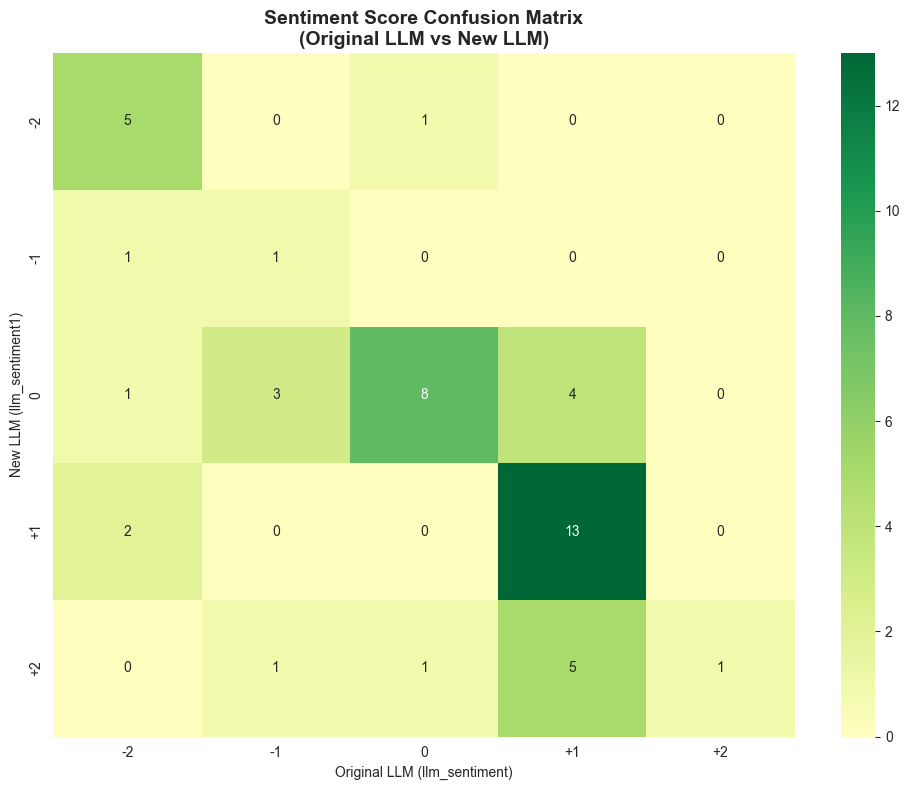

In [12]:
# Confusion matrix for sentiment scores
if total_sentiment > 0:
    cm_sentiment = confusion_matrix(df_both_sentiment['llm_sentiment'], df_both_sentiment['llm_sentiment1'], 
                                     labels=[-2, -1, 0, 1, 2])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='RdYlGn', center=0,
                xticklabels=['-2', '-1', '0', '+1', '+2'],
                yticklabels=['-2', '-1', '0', '+1', '+2'])
    plt.title('Sentiment Score Confusion Matrix\n(Original LLM vs New LLM)', fontsize=14, fontweight='bold')
    plt.ylabel('New LLM (llm_sentiment1)')
    plt.xlabel('Original LLM (llm_sentiment)')
    plt.tight_layout()
    plt.show()

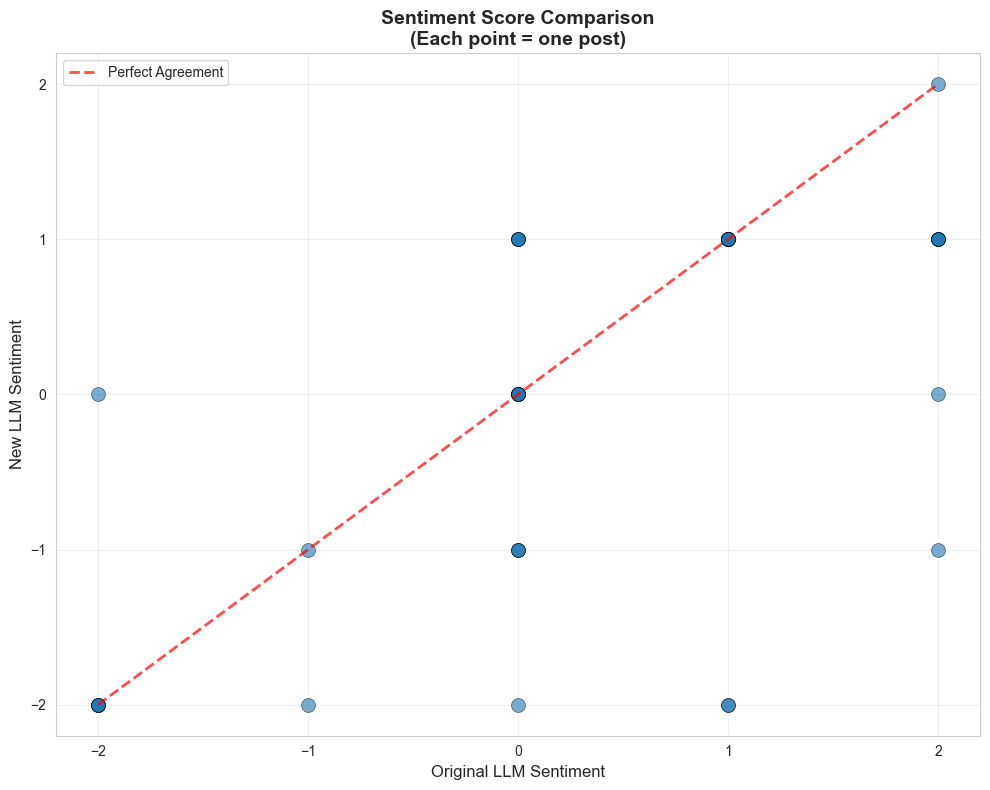


Points on the diagonal line = perfect agreement
Points above the line = New LLM rated more positively
Points below the line = Original LLM rated more positively


In [13]:
# Scatter plot: Original vs New sentiment scores
if total_sentiment > 0:
    plt.figure(figsize=(10, 8))
    plt.scatter(df_both_sentiment['llm_sentiment'], df_both_sentiment['llm_sentiment1'], 
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    
    # Add diagonal line (perfect agreement)
    plt.plot([-2, 2], [-2, 2], 'r--', linewidth=2, label='Perfect Agreement', alpha=0.7)
    
    plt.xlabel('Original LLM Sentiment', fontsize=12)
    plt.ylabel('New LLM Sentiment', fontsize=12)
    plt.title('Sentiment Score Comparison\n(Each point = one post)', fontsize=14, fontweight='bold')
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([-2, -1, 0, 1, 2])
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nPoints on the diagonal line = perfect agreement")
    print("Points above the line = New LLM rated more positively")
    print("Points below the line = Original LLM rated more positively")

In [ ]:
# Show examples where sentiment disagreed significantly (diff >= 2)
if total_sentiment > 0:
    large_disagreements = df_both_sentiment[df_both_sentiment['sentiment_diff'].abs() >= 2]
    
    print(f"\n{len(large_disagreements)} posts with large sentiment disagreements (|diff| >= 2):")
    print("="*100)
    
    for idx, row in large_disagreements.head(10).iterrows():
        print(f"\nPost: {row['full_text'][:150]}...")
        print(f"  Original sentiment: {int(row['llm_sentiment']):+d}")
        print(f"  New sentiment: {int(row['llm_sentiment1']):+d}")
        print(f"  Difference: {int(row['sentiment_diff']):+d}")
        print(f"  Original reasoning: {row['llm_reasoning']}")
        print(f"  New reasoning: {row['llm_reasoning1']}")
        print("-"*100)

## Summary Statistics

In [14]:
print("="*100)
print("SUMMARY: LLM SENTIMENT ANNOTATION CONSISTENCY")
print("="*100)

if total_sentiment > 0:
    print(f"\nTotal posts compared: {total_sentiment}")
    print(f"Exact match rate: {exact_agreement_rate:.1f}%")
    print(f"Cohen's Kappa: {kappa_sentiment:.3f}")
    print(f"Mean absolute difference: {mad:.2f} points")

print("\n" + "="*100)

SUMMARY: LLM SENTIMENT ANNOTATION CONSISTENCY

Total posts compared: 47
Exact match rate: 59.6%
Cohen's Kappa: 0.458
Mean absolute difference: 0.60 points

